# LDA & Deep-LDA - Toy model

Data-driven collective variables built upon Fisher's discriminant analysis, both in its linear and non-linear version.

**System**: Wolfe-Quapp 2D potential (rotated)

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from mlcvs.utils.io import load_dataframe

Helper function to load data

In [11]:
def load_dataset_2d_model():
    """Load 2d-basins dataset"""

    # Load colvar files as pandas dataframes
    dataA = load_dataframe("data/2d_model/COLVAR_stateA")
    dataB = load_dataframe("data/2d_model/COLVAR_stateB")

    # Create input datasets
    xA = dataA.filter(regex="p.*").values
    xB = dataB.filter(regex="p.*").values
    names = dataA.filter(regex="p.*").columns.values

    # Create labels
    yA = np.zeros(len(dataA))
    yB = np.ones(len(dataB))

    # Concatenate
    X = np.concatenate([xA, xB], axis=0)
    y = np.concatenate([yA, yB], axis=0)

    # Shuffle
    np.random.seed(1)
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    # Convert np to torch.Tensors
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    return X, y, names

Plotting functions

In [12]:
def plot_isolines_grid(cv,limits=((-3,3),(-3,3)),num_points=(50,50),scatter=None,ax=None):

    if type(num_points) == int:
        num_points = (num_points,num_points)

    # Define grid and evaluate cv on it
    xx = np.linspace(limits[0][0],limits[0][1],num_points[0])
    yy = np.linspace(limits[1][0],limits[1][1],num_points[1])
    xv, yv = np.meshgrid(xx, yy, indexing='xy')
    z = np.zeros_like(xv)
    for i in range(num_points[0]):
        for j in range(num_points[1]):
            xy = torch.Tensor([xv[i,j], yv[i,j]])
            z[i,j] = cv(xy)

    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title(f'{cv.name_} isolines')

    # Plot countour plot
    h = ax.contourf(xx, yy, z)
    cbar = plt.colorbar(h,ax=ax)
    cbar.set_label(f'{cv.name_}')

    # Scatter plot with training data
    if scatter is not None:
        ax.scatter(scatter[:,0],scatter[:,1],s=2,c='white',alpha=0.5)
        ax.set_aspect('equal') 

def plot_cv_histogram(s,label=None,ax=None,**kwargs):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title('Histogram')

    if (type(s)==torch.Tensor):
        s = s.squeeze(1).detach().numpy()

    # Plot histogram
    ax.hist(s,**kwargs)
    if label is not None:
        ax.set_xlabel(label)


## HLDA: Harmonic Linear Discriminant Analysis

Reference: _Mendels, Piccini, Parrinello, JCPL 2018_.

### Load data

In [13]:
X, y, feature_names = load_dataset_2d_model()

### Train CV

In [14]:
from mlcvs.lda import LDA_CV

hlda = LDA_CV(n_features=X.shape[1], harmonic_lda=True)

hlda.fit(X, y)

### Plot results

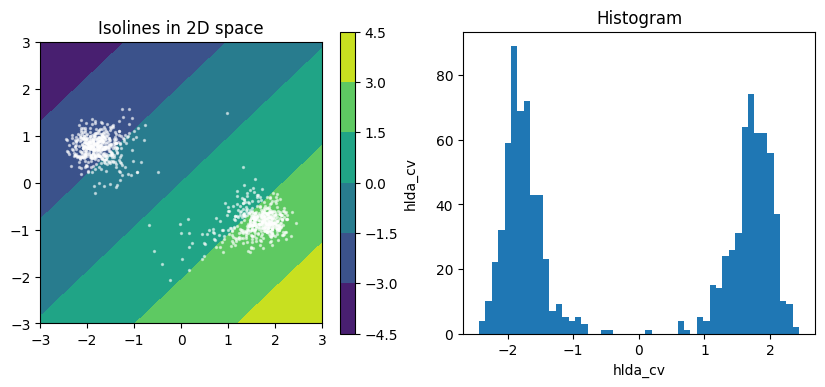

In [15]:
_, axs = plt.subplots(1,2, figsize=(10,4.), dpi=100)

# CV isolines
axs[0].set_title(f'Isolines in 2D space')
plot_isolines_grid(hlda, scatter=X, num_points=50, ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Histogram')
s = hlda(X)
plot_cv_histogram(s,label=hlda.name_,bins=50, ax=axs[1] )

### Get PLUMED input

In [16]:
hlda.set_params({"feature_names": feature_names})
print( hlda.plumed_input() )

hlda_cv: CUSTOM ARG=p.x,p.y VAR=x0,x1 FUNC=0.689055*x0-0.724709*x1 PERIODIC=NO



## Deep-LDA: Neural network-based discriminant analysis

Reference: _Bonati, Rizzi, Parrinello, JCPL 2020_.

### Load data

In [17]:
X, y, feature_names = load_dataset_2d_model()
n_features = X.shape[1]

# split train/test
ntrain,nvalid = 800,200

# ... replace with dataloder from file

### Train CV

In [19]:
from mlcvs.lda import DeepLDA_CV

#------------- PARAMETERS -------------
nodes             = [n_features,30,30,5]

lrate             = 0.001
sw_reg            = 0.05
l2_reg            = 1e-5

num_epochs        = 1000
earlystop         = True
es_patience       = 20
es_consecutive    = False
es_min_delta      = 0.05

log_every         = 100
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepLDA_CV(nodes)
model.set_device(device)

# REGULARIZATION
model.set_regularization(sw_reg=sw_reg)
model.set_earlystopping(patience=es_patience,consecutive=es_consecutive,min_delta=es_min_delta)

# TRAIN
model.fit(X=X,y=y, standardize_inputs = True, log_every=log_every)

# standardize outputs
#model.standardize_outputs(train_data[0].to(device))

Created dataloaders
Training   set: 801
Validation set: 201
Epoch Train Loss  Valid Loss  
100   -58.293 -59.308 
200   -62.035 -62.273 
300   -62.466 -62.432 
400   -62.631 -62.502 
500   -62.700 -62.519 
600   -62.696 -62.521 
700   -62.719 -62.521 
800   -62.716 -62.526 
900   -62.738 -62.528 
1000  -62.738 -62.546 


In [20]:
# get back to CPU
model.to('cpu')

DeepLDA_CV(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
  )
)

### Plot learning curve

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

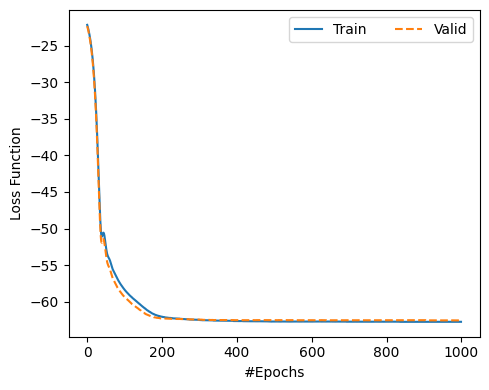

In [21]:
fig, ax = plt.subplots(figsize=(5,4),dpi=100)

loss_train = [x for x in model.loss_train]
loss_valid = [x for x in model.loss_valid]

# Loss function
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')

#if model.earlystopping_.early_stop:
#    ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
ax.set_xlabel('#Epochs')
ax.legend(ncol=2)

plt.tight_layout()
plt.show()

### Plot results

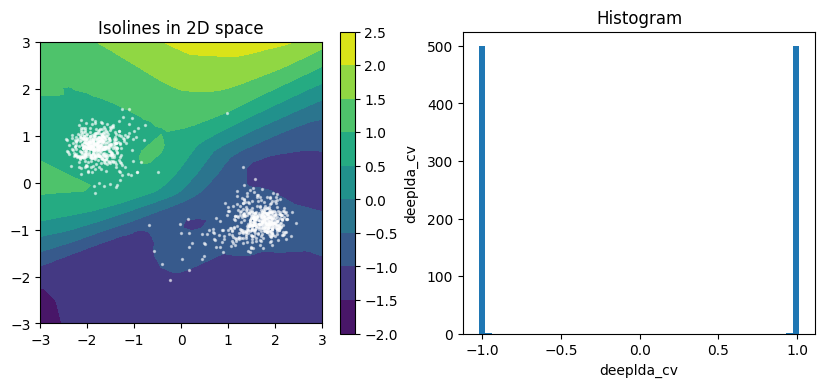

In [22]:
_, axs = plt.subplots(1,2, figsize=(10,4.), dpi=100)

# CV isolines
axs[0].set_title(f'Isolines in 2D space')
plot_isolines_grid(model, scatter=X, num_points=50, ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Histogram')
s = model(X)
plot_cv_histogram(s,label=model.name_,bins=50, ax=axs[1] )